## Post Sentiment Classification Task

In [1]:
import pandas as pd
import numpy as np

train_data = pd.read_json("https://raw.githubusercontent.com/rpsoft/tad_course/main/reddit_sentiment_train.json")

validation_data = pd.read_json("https://raw.githubusercontent.com/rpsoft/tad_course/main/reddit_sentiment_validation.json")

test_data = pd.read_json("https://raw.githubusercontent.com/rpsoft/tad_course/main/reddit_sentiment_test.json")

In [41]:
import spacy
import nltk
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import fbeta_score

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.pipeline import FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

# Q1

In [37]:
#check the training data
train_data.head(5)

,subreddit,title,id,url,author,body,majority_type,is_first_post,post_depth,in_reply_to,sentiment.polarity,sentiment.subjectivity
0,relationships,My Friend/Crush [22/F] acting weird after I [2...,t1_cy7f317,https://www.reddit.com/r/relationships/comment...,Melodrama_,"It's a sad realization, isn't it?",,False,2,t1_cy7erc5,negative,1.000000
1,relationships,My Friend/Crush [22/F] acting weird after I [2...,t1_cy7hlyf,https://www.reddit.com/r/relationships/comment...,Melodrama_,I told her a couple of minutes ago that I didn...,elaboration,False,2,t1_cy7erc5,neutral,0.483631
2,relationships,My Friend/Crush [22/F] acting weird after I [2...,t1_cy7etrr,https://www.reddit.com/r/relationships/comment...,TreatYoSelves,Leeches don't make good friends.,answer,False,1,t3_3xshx9,positive,0.600000
3,relationships,My Friend/Crush [22/F] acting weird after I [2...,t1_cy7hhpq,https://www.reddit.com/r/relationships/comment...,Melodrama_,I just ended it. Apparently she wasn't a good ...,elaboration,False,2,t1_cy7etrr,positive,0.475000
4,relationships,My Friend/Crush [22/F] acting weird after I [2...,t1_cy7q0qg,https://www.reddit.com/r/relationships/comment...,TreatYoSelves,Good for you! Make sure you stick with it.,appreciation,False,3,t1_cy7hhpq,positive,0.744444


neutral          7679
positive         3231
negative          878
very positive     253
very negative      97
Name: sentiment.polarity, dtype: int64


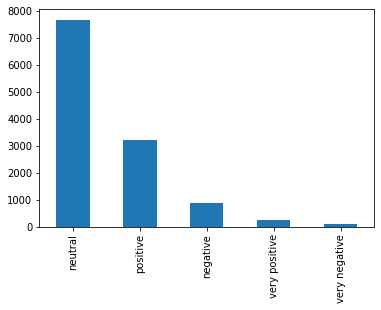

In [8]:
polarity_counts = train_data['sentiment.polarity'].value_counts()
print(polarity_counts)
polarity_counts.plot.bar()

neutral          1961
positive          845
negative          215
very positive      73
very negative      15
Name: sentiment.polarity, dtype: int64


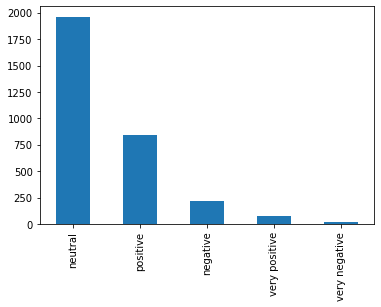

In [7]:
polarity_counts = validation_data['sentiment.polarity'].value_counts()
print(polarity_counts)
polarity_counts.plot.bar()

neutral          2514
positive         1102
negative          282
very positive      86
very negative      32
Name: sentiment.polarity, dtype: int64


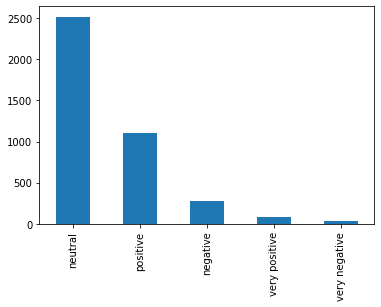

In [9]:
polarity_counts = test_data['sentiment.polarity'].value_counts()
print(polarity_counts)
polarity_counts.plot.bar()

In [3]:
nlp = spacy.load('en_core_web_sm')
nlp.remove_pipe('tagger')
nlp.remove_pipe('parser')

('parser', <spacy.pipeline.pipes.DependencyParser at 0x7fb57215e3d0>)

In [4]:
#download a stopword list
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [5]:
#tokenize
def spacy_tokenize(string):
  tokens = list()
  doc = nlp(string)
  for token in doc:
    tokens.append(token)
  return tokens

#normalize
def normalize(tokens):
  normalized_tokens = list()
  for token in tokens:
    normalized = token.text.lower().strip()
    if ((token.is_alpha or token.is_digit)):
      normalized_tokens.append(normalized)
  return normalized_tokens
  return normalized_tokens

#tokenize and normalize
def tokenize_normalize(string):
  return normalize(spacy_tokenize(string))

In [9]:
# use smaller datasets
# train_data = train_data[0:500]
# validation_data = validation_data[0:500]
# test_data = test_data[0:500]

In [42]:
# Pass in the tokenizer as the tokenizer to the vectorizer.
# Create a one-hot encoding vectorizer.
one_hot_vectorizer = CountVectorizer(tokenizer=tokenize_normalize, binary=True)
train_features = one_hot_vectorizer.fit_transform(train_data['body'])

# This creates input features for our classification on all subsets of our collection.
validation_features = one_hot_vectorizer.transform(validation_data['body'])
test_features = one_hot_vectorizer.transform(test_data['body'])

In [7]:
train_labels = train_data['sentiment.polarity']
validation_labels = validation_data['sentiment.polarity']
test_labels = test_data['sentiment.polarity']

In [6]:
def evaluation_summary(description, predictions, true_labels):
  print("Evaluation for: " + description)
  precision = precision_score(predictions, true_labels, average='weighted')
  recall = recall_score(predictions, true_labels, average='weighted')
  accuracy = accuracy_score(predictions, true_labels)
  f1_weighted = fbeta_score(predictions, true_labels, 1, average='weighted') #1 means f_1 measure
  f1_macro = fbeta_score(predictions, true_labels, 1, average='macro')
  print("Classifier '%s' has Acc=%0.3f P=%0.3f R=%0.3f F1_w=%0.3f F1_m=%0.3f" % (description,accuracy,precision,recall,f1_weighted,f1_macro))
  print(classification_report(predictions, true_labels, digits=3, zero_division = 0))
  print('\nConfusion matrix:\n',confusion_matrix(true_labels, predictions)) # Note the order here is true, predicted


## Dummy Classifier
1. `Dummy Classifier` with `strategy="most_frequent"`

2. `Dummy Classifier` with `strategy="stratified"`

In [43]:
dummy_mf = DummyClassifier(strategy='most_frequent')
dummy_mf.fit(train_features, train_labels)
print(dummy_mf.score(test_features, test_labels))
evaluation_summary("Dummy Majority", dummy_mf.predict(test_features), test_labels)

0.625996015936255
Evaluation for: Dummy Majority
Classifier 'Dummy Majority' has Acc=0.626 P=1.000 R=0.626 F1_w=0.770 F1_m=0.154
               precision    recall  f1-score   support

     negative      0.000     0.000     0.000         0
      neutral      1.000     0.626     0.770      4016
     positive      0.000     0.000     0.000         0
very negative      0.000     0.000     0.000         0
very positive      0.000     0.000     0.000         0

     accuracy                          0.626      4016
    macro avg      0.200     0.125     0.154      4016
 weighted avg      1.000     0.626     0.770      4016


Confusion matrix:
 [[   0  282    0    0    0]
 [   0 2514    0    0    0]
 [   0 1102    0    0    0]
 [   0   32    0    0    0]
 [   0   86    0    0    0]]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [44]:
dummy_prior = DummyClassifier(strategy='stratified')
dummy_prior.fit(train_features, train_labels)
print(dummy_prior.score(test_features, test_labels))
evaluation_summary("Dummy Prior", dummy_prior.predict(test_features), test_labels)

0.4676294820717131
Evaluation for: Dummy Prior
Classifier 'Dummy Prior' has Acc=0.462 P=0.463 R=0.462 F1_w=0.462 F1_m=0.190
               precision    recall  f1-score   support

     negative      0.060     0.057     0.059       296
      neutral      0.619     0.614     0.616      2535
     positive      0.256     0.268     0.262      1054
very negative      0.000     0.000     0.000        36
very positive      0.012     0.011     0.011        95

     accuracy                          0.462      4016
    macro avg      0.189     0.190     0.190      4016
 weighted avg      0.463     0.462     0.462      4016


Confusion matrix:
 [[  17  192   64    4    5]
 [ 194 1556  678   21   65]
 [  73  714  282    9   24]
 [   3   21    8    0    0]
 [   9   52   22    2    1]]


## Logistic Regression
3. `LogisticRegression` with `One-hot vectorization`

In [15]:
lr = LogisticRegression(solver='saga', max_iter = 1000)
lr_model = lr.fit(train_features, train_labels)
evaluation_summary("LR onehot", lr_model.predict(test_features), test_labels)

Evaluation for: LR onehot
Classifier 'LR onehot' has Acc=0.748 P=0.787 R=0.748 F1_w=0.763 F1_m=0.476
               precision    recall  f1-score   support

     negative      0.245     0.479     0.324       144
      neutral      0.877     0.778     0.825      2835
     positive      0.635     0.714     0.672       980
very negative      0.125     0.667     0.211         6
very positive      0.279     0.471     0.350        51

     accuracy                          0.748      4016
    macro avg      0.432     0.622     0.476      4016
 weighted avg      0.787     0.748     0.763      4016


Confusion matrix:
 [[  69  204    8    1    0]
 [  67 2206  227    1   13]
 [   3  385  700    0   14]
 [   5   23    0    4    0]
 [   0   17   45    0   24]]


4. `LogisticRegression` with `TF-IDF vectorization` **(default settings)**

In [18]:
ngram_vectorizer = TfidfVectorizer(tokenizer=tokenize_normalize)
train_features_idf = ngram_vectorizer.fit_transform(train_data['body'])

validation_features_idf = ngram_vectorizer.transform(validation_data['body'])
test_features_idf = ngram_vectorizer.transform(test_data['body'])

In [19]:
lr_idf = LogisticRegression(solver='saga', max_iter = 1000)
lr_idf_model = lr_idf.fit(train_features_idf, train_labels)
evaluation_summary("LR tf-idf", lr_idf_model.predict(test_features_idf), test_labels)

Evaluation for: LR tf-idf
Classifier 'LR tf-idf' has Acc=0.741 P=0.853 R=0.741 F1_w=0.780 F1_m=0.356
               precision    recall  f1-score   support

     negative      0.089     0.625     0.155        40
      neutral      0.944     0.738     0.829      3212
     positive      0.517     0.758     0.615       752
very negative      0.000     0.000     0.000         0
very positive      0.105     0.750     0.184        12

     accuracy                          0.741      4016
    macro avg      0.331     0.574     0.356      4016
 weighted avg      0.853     0.741     0.780      4016


Confusion matrix:
 [[  25  249    8    0    0]
 [  11 2372  130    0    1]
 [   0  530  570    0    2]
 [   4   28    0    0    0]
 [   0   33   44    0    9]]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


5. `SVC Classifier` with `One-hot vectorization` **(SVM with RBF kernel, default settings))**

In [18]:
svc = SVC(kernel='rbf')
svc.fit(train_features, train_labels)
evaluation_summary("SVC", svc.predict(test_features), test_labels)

Evaluation for: SVC
Classifier 'SVC' has Acc=0.730 P=0.875 R=0.730 F1_w=0.782 F1_m=0.287
               precision    recall  f1-score   support

     negative      0.014     0.800     0.028         5
      neutral      0.958     0.721     0.823      3339
     positive      0.470     0.771     0.584       672
very negative      0.000     0.000     0.000         0
very positive      0.000     0.000     0.000         0

     accuracy                          0.730      4016
    macro avg      0.288     0.458     0.287      4016
 weighted avg      0.875     0.730     0.782      4016


Confusion matrix:
 [[   4  270    8    0    0]
 [   0 2409  105    0    0]
 [   0  584  518    0    0]
 [   1   31    0    0    0]
 [   0   45   41    0    0]]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [19]:
knn = KNeighborsClassifier(n_neighbors=7)
knn_model = knn.fit(train_features_idf, train_labels)
evaluation_summary("KNN", knn_model.predict(test_features_idf), test_labels)

Evaluation for: KNN
Classifier 'KNN' has Acc=0.634 P=0.991 R=0.634 F1_w=0.768 F1_m=0.171
               precision    recall  f1-score   support

     negative      0.004     1.000     0.007         1
      neutral      1.000     0.631     0.774      3981
     positive      0.027     0.909     0.053        33
very negative      0.000     0.000     0.000         0
very positive      0.012     1.000     0.023         1

     accuracy                          0.634      4016
    macro avg      0.208     0.708     0.171      4016
 weighted avg      0.991     0.634     0.768      4016


Confusion matrix:
 [[   1  281    0    0    0]
 [   0 2513    1    0    0]
 [   0 1072   30    0    0]
 [   0   32    0    0    0]
 [   0   83    2    0    1]]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


From the results above, we can see the classifier `LogisticRegression` with `One-hot vectorization` has the highest macro F1 score.

<BarContainer object of 5 artists>

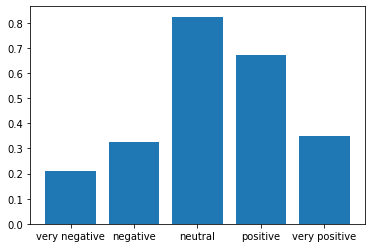

In [20]:
f1score = np.array([0.211, 0.324, 0.825, 0.672, 0.350])
labels= ["very negative", "negative", "neutral", "positive", "very positive"]

plt.bar(labels, f1score)

# Q2

In [9]:
class ItemSelector(BaseEstimator, TransformerMixin):
    """For data grouped by feature, select subset of data at a provided key.    """

    def __init__(self, key):
        self.key = key

    def fit(self, x, y = None):
        return self

    def transform(self, data_dict):
        return data_dict[self.key]

In [10]:
prediction_pipeline = Pipeline([
              ('selector', ItemSelector(key='body')),
              ('tf-idf', TfidfVectorizer()),
              ('logreg', LogisticRegression(solver='saga', max_iter = 1000))
              ])

In [49]:
params = {
    'logreg__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000],
    'tf-idf__sublinear_tf': [True, False],
    'tf-idf__max_features': range(0, 50000, 1000),
}

grid_search = GridSearchCV(prediction_pipeline, param_grid=params, n_jobs=1, verbose=1, scoring='f1_macro', cv=2)
grid_search.fit(train_data, train_labels)
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(params.keys()):
  print("\t%s: %r" % (param_name, best_parameters[param_name]))

Fitting 2 folds for each of 900 candidates, totalling 1800 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: After pruning, no terms remain. Try a lower min_df or a higher max_df.

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: After pruning, no terms remain. Try a lower min_df or a higher max_df.

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: After pruning, no terms remain. Try a lower min_df or a high

	logreg__C: 100
	tf-idf__max_features: 3000
	tf-idf__sublinear_tf: False


In [33]:
from sklearn.model_selection import GridSearchCV

params_2 = {
    'tf-idf__max_df': [1000, 1200, 1400, 1600, 1800]
}

grid_search_2 = GridSearchCV(prediction_pipeline, param_grid=params_2, n_jobs=1, verbose=1, scoring='f1_macro', cv=2)
grid_search_2.fit(train_data, train_labels)
best_parameters = grid_search_2.best_estimator_.get_params()
for param_name in sorted(params_2.keys()):
  print("\t%s: %r" % (param_name, best_parameters[param_name]))

Fitting 2 folds for each of 5 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    6.9s finished


	tf-idf__max_df: 1200


In [11]:
prediction_pipeline_tuned = Pipeline([
              ('selector', ItemSelector(key='body')),
              ('tf-idf', TfidfVectorizer(sublinear_tf=False, max_features=3000)),
              ('logreg', LogisticRegression(solver='saga', max_iter = 1000, C=100))
              ])
prediction_pipeline_tuned.fit(train_data, train_labels)
evaluation_summary("LR tf-idf", prediction_pipeline_tuned.predict(test_data), test_labels)

Evaluation for: LR tf-idf
Classifier 'LR tf-idf' has Acc=0.747 P=0.756 R=0.747 F1_w=0.751 F1_m=0.512
               precision    recall  f1-score   support

     negative      0.355     0.427     0.388       234
      neutral      0.834     0.804     0.819      2607
     positive      0.694     0.713     0.703      1073
very negative      0.250     0.320     0.281        25
very positive      0.349     0.390     0.368        77

     accuracy                          0.747      4016
    macro avg      0.496     0.531     0.512      4016
 weighted avg      0.756     0.747     0.751      4016


Confusion matrix:
 [[ 100  167    9    5    1]
 [ 119 2096  264   12   23]
 [   5  309  765    0   23]
 [   9   15    0    8    0]
 [   1   20   35    0   30]]


In [12]:
 prediction_pipeline_tuned = Pipeline([
              ('selector', ItemSelector(key='body')),
              ('tf-idf', TfidfVectorizer(sublinear_tf=False, max_features=3000, max_df=1200)),
              ('logreg', LogisticRegression(solver='saga', max_iter = 1000, C=100))
              ])
prediction_pipeline_tuned.fit(train_data, train_labels)
evaluation_summary("LR tf-idf", prediction_pipeline_tuned.predict(test_data), test_labels)

Evaluation for: LR tf-idf
Classifier 'LR tf-idf' has Acc=0.750 P=0.758 R=0.750 F1_w=0.753 F1_m=0.541
               precision    recall  f1-score   support

     negative      0.404     0.485     0.441       235
      neutral      0.836     0.805     0.820      2610
     positive      0.685     0.702     0.693      1076
very negative      0.344     0.458     0.393        24
very positive      0.326     0.394     0.357        71

     accuracy                          0.750      4016
    macro avg      0.519     0.569     0.541      4016
 weighted avg      0.758     0.750     0.753      4016


Confusion matrix:
 [[ 114  154    8    4    2]
 [ 109 2102  273    9   21]
 [   6  321  755    0   20]
 [   5   14    2   11    0]
 [   1   19   38    0   28]]


In [13]:
# print 20 pieces of mispredicted data
predicted = prediction_pipeline_tuned.predict(test_data)

p = 0
for i in range(len(test_labels)):
  if p < 20:
    if test_labels[i] != predicted[i]:
      print(test_data['body'][i] + '\n\nTrue label: ' + test_labels[i] + ' Predicted label: ' + predicted[i] + '\n')
      p += 1
  else:
    break

Was watching a VOD from last years DreamHack Winter. The first map in the finals (Naama vs Mana) was Lost Temple.. spawning close ground positions..

It's a great sign that shows how much the game is evolving imo. Has anyone else noticed stuff like this?

True label: neutral Predicted label: positive

I find it cool that both Mana and Naama made it to the Ro16 in this DH Winter. Shows that they weren't just flashes in the pan.

True label: positive Predicted label: neutral

Even better, watch a VOD from [MLG Raleigh](http://tv.majorleaguegaming.com/videos/174-wr4-g2-kiwikaki-vs-nadagast-steppes-of-war-mlg-raleigh-starcraft-2)

The games, the casting, the maps... everything was fucking awful.  Amazing that it was just over one year ago.

True label: neutral Predicted label: positive

Your name and your post do not correlate 

True label: neutral Predicted label: very positive

Deadpool just has scars because of the cancer doesn't he?
Well stabbing him with kryptonite wouldn't be as effe

# Q3

In [15]:
# add title and majority_type to the model
prediction_pipeline_union = Pipeline([
        ('union', FeatureUnion(
          transformer_list=[
            ('title', Pipeline([
              ('selector', ItemSelector(key='title')),
              ('one-hot', TfidfVectorizer(norm='l1')), 
              ])),
            ('body', Pipeline([
              ('selector', ItemSelector(key='body')), 
              ('one-hot', TfidfVectorizer(sublinear_tf=False, max_features=3000, max_df=1200)), 
              ])),
            ('type', Pipeline([
              ('selector', ItemSelector(key='majority_type')),
              ('one-hot', TfidfVectorizer(norm='l1')), 
              ])),
        ])
        )
    ])

In [16]:
train_features_union = prediction_pipeline_union.fit_transform(train_data)
validation_features_union = prediction_pipeline_union.transform(validation_data)
test_features_union = prediction_pipeline_union.transform(test_data)

In [17]:
clf = LogisticRegression(solver='saga', max_iter = 1000, C=100)
combined = clf.fit(train_features_union, train_labels)
evaluation_summary("LR tf-idf", combined.predict(test_features_union), test_labels)

Evaluation for: LR tf-idf
Classifier 'LR tf-idf' has Acc=0.735 P=0.747 R=0.735 F1_w=0.740 F1_m=0.536
               precision    recall  f1-score   support

     negative      0.372     0.471     0.416       223
      neutral      0.833     0.789     0.810      2654
     positive      0.645     0.680     0.662      1045
very negative      0.344     0.524     0.415        21
very positive      0.349     0.411     0.377        73

     accuracy                          0.735      4016
    macro avg      0.509     0.575     0.536      4016
 weighted avg      0.747     0.735     0.740      4016


Confusion matrix:
 [[ 105  162   11    3    1]
 [ 102 2094  287    7   24]
 [  10  363  711    0   18]
 [   6   14    1   11    0]
 [   0   21   35    0   30]]


In [18]:
# add only title
prediction_pipeline_union = Pipeline([
        ('union', FeatureUnion(
          transformer_list=[
            ('title', Pipeline([
              ('selector', ItemSelector(key='title')),
              ('one-hot', TfidfVectorizer(norm='l1')), 
              ])),
            ('body', Pipeline([
              ('selector', ItemSelector(key='body')), 
              ('one-hot', TfidfVectorizer(sublinear_tf=False, max_features=3000, max_df=1200)), 
              ])),
        ])
        )
    ])

train_features_union = prediction_pipeline_union.fit_transform(train_data)
validation_features_union = prediction_pipeline_union.transform(validation_data)
test_features_union = prediction_pipeline_union.transform(test_data)

clf = LogisticRegression(solver='saga', max_iter = 1000, C=100)
combined = clf.fit(train_features_union, train_labels)
evaluation_summary("LR tf-idf", combined.predict(test_features_union), test_labels)

Evaluation for: LR tf-idf
Classifier 'LR tf-idf' has Acc=0.736 P=0.750 R=0.736 F1_w=0.742 F1_m=0.523
               precision    recall  f1-score   support

     negative      0.348     0.456     0.394       215
      neutral      0.835     0.788     0.811      2662
     positive      0.652     0.679     0.665      1057
very negative      0.250     0.444     0.320        18
very positive      0.372     0.500     0.427        64

     accuracy                          0.736      4016
    macro avg      0.491     0.574     0.523      4016
 weighted avg      0.750     0.736     0.742      4016


Confusion matrix:
 [[  98  169   11    2    2]
 [  98 2098  292    8   18]
 [  12  360  718    0   12]
 [   7   15    2    8    0]
 [   0   20   34    0   32]]


In [36]:
# add only author
prediction_pipeline_union = Pipeline([
        ('union', FeatureUnion(
          transformer_list=[
            ('author', Pipeline([
              ('selector', ItemSelector(key='author')),
              ('one-hot', TfidfVectorizer(norm='l1')), 
              ])),
            ('body', Pipeline([
              ('selector', ItemSelector(key='body')), 
              ('one-hot', TfidfVectorizer(sublinear_tf=False, max_features=3000, max_df=1200)), 
              ])),
        ])
        )
    ])

train_features_union = prediction_pipeline_union.fit_transform(train_data)
validation_features_union = prediction_pipeline_union.transform(validation_data)
test_features_union = prediction_pipeline_union.transform(test_data)

clf = LogisticRegression(solver='saga', max_iter = 1000, C=100)
combined = clf.fit(train_features_union, train_labels)
evaluation_summary("LR tf-idf", combined.predict(test_features_union), test_labels)

Evaluation for: LR tf-idf
Classifier 'LR tf-idf' has Acc=0.738 P=0.776 R=0.738 F1_w=0.752 F1_m=0.501
               precision    recall  f1-score   support

     negative      0.259     0.514     0.344       142
      neutral      0.869     0.772     0.817      2832
     positive      0.610     0.682     0.644       986
very negative      0.219     0.538     0.311        13
very positive      0.291     0.581     0.388        43

     accuracy                          0.738      4016
    macro avg      0.449     0.617     0.501      4016
 weighted avg      0.776     0.738     0.752      4016


Confusion matrix:
 [[  73  193   13    2    1]
 [  56 2185  262    4    7]
 [   6  414  672    0   10]
 [   7   16    2    7    0]
 [   0   24   37    0   25]]


In [19]:
# add only majority_type
prediction_pipeline_union = Pipeline([
        ('union', FeatureUnion(
          transformer_list=[
            ('type', Pipeline([
              ('selector', ItemSelector(key='majority_type')),
              ('one-hot', TfidfVectorizer(norm='l1')), 
              ])),
            ('body', Pipeline([
              ('selector', ItemSelector(key='body')), 
              ('one-hot', TfidfVectorizer(sublinear_tf=False, max_features=3000, max_df=1200)), 
              ])),
        ])
        )
    ])

train_features_union = prediction_pipeline_union.fit_transform(train_data)
validation_features_union = prediction_pipeline_union.transform(validation_data)
test_features_union = prediction_pipeline_union.transform(test_data)

clf = LogisticRegression(solver='saga', max_iter = 1000, C=100)
combined = clf.fit(train_features_union, train_labels)
evaluation_summary("LR tf-idf", combined.predict(test_features_union), test_labels)

Evaluation for: LR tf-idf
Classifier 'LR tf-idf' has Acc=0.750 P=0.757 R=0.750 F1_w=0.753 F1_m=0.530
               precision    recall  f1-score   support

     negative      0.401     0.477     0.435       237
      neutral      0.835     0.809     0.822      2596
     positive      0.691     0.709     0.699      1074
very negative      0.344     0.407     0.373        27
very positive      0.314     0.329     0.321        82

     accuracy                          0.750      4016
    macro avg      0.517     0.546     0.530      4016
 weighted avg      0.757     0.750     0.753      4016


Confusion matrix:
 [[ 113  154    8    5    2]
 [ 111 2099  266   11   27]
 [   6  309  761    0   26]
 [   6   14    1   11    0]
 [   1   20   38    0   27]]


In [32]:
# add only sentiment.subjectivity

numeric_features = ['sentiment.subjectivity']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

text_features = ['body']
text_transformer = TfidfVectorizer(sublinear_tf=False, max_features=3000, max_df=1200)


preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('tfidf_1', text_transformer, 'body'),],
                    remainder='drop')


## Run evaluation with classifier
def evaluateClassifier(classif):
  clf = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', classif)])

  clf.fit(train_data, train_labels)

  y_pred = clf.predict(test_data)

  print(metrics.classification_report(test_labels, y_pred, zero_division=0))

evaluateClassifier(LogisticRegression(solver='saga', max_iter = 1000, C=100))

               precision    recall  f1-score   support

     negative       0.49      0.46      0.48       282
      neutral       0.85      0.86      0.86      2514
     positive       0.74      0.74      0.74      1102
very negative       0.47      0.50      0.48        32
very positive       0.46      0.38      0.42        86

     accuracy                           0.79      4016
    macro avg       0.60      0.59      0.60      4016
 weighted avg       0.78      0.79      0.79      4016



In [35]:
# add sentiment.subjectivity and majority_type

numeric_features = ['sentiment.subjectivity']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

text_features = ['body', 'majority_type']
text_transformer = TfidfVectorizer(sublinear_tf=False, max_features=3000, max_df=1200)


preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('tfidf_1', text_transformer, 'body'),
        ('tfidf_2', text_transformer, 'majority_type')],
                    remainder='drop')


## Run evaluation with classifier
def evaluateClassifier(classif):
  clf = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', classif)])

  clf.fit(train_data, train_labels)

  y_pred = clf.predict(test_data)

  print(metrics.classification_report(test_labels, y_pred, zero_division=0))

evaluateClassifier(LogisticRegression(solver='saga', max_iter = 1000, C=100))

               precision    recall  f1-score   support

     negative       0.50      0.47      0.49       282
      neutral       0.85      0.86      0.86      2514
     positive       0.74      0.73      0.74      1102
very negative       0.55      0.50      0.52        32
very positive       0.42      0.38      0.40        86

     accuracy                           0.79      4016
    macro avg       0.61      0.59      0.60      4016
 weighted avg       0.78      0.79      0.79      4016

